In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm import tqdm
import ast 

import pandas as pd
import json

from collections import defaultdict, Counter
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Task 4: Causality/Correlation

## Context 

Now that we have a more robust sentiment analysis tool, we can focus on the analysis. <br>
In this notebook, we'll test the correlation of possible causality of the data.

## Read data

We start by reading sentiment data and smoothing it over a window of 7 days. We also read data and metrics about bitcoin and fear index.

In [ ]:
cd /content/drive/MyDrive/ADA_Proj

/content/drive/MyDrive/ADA_Proj


In [ ]:
quotes = pd.read_csv("./M3/Data/bitcoin_data_with_sentiment_final.csv")
quotes['date'] = pd.to_datetime(quotes['date']).dt.to_period('D')
quotes['sentiment'] = quotes['score'].apply(lambda x: 'positive' if x>=0 else 'negative')
quotes['qids'] = quotes['qids'].apply(ast.literal_eval)


In [ ]:
quotes_ = quotes.copy()
# Take the median to handle noisy data
quotes_by_day = quotes_.groupby('date',as_index=False).agg({"score":"mean", "numOccurrences":"count"})
quotes_by_day['ewm_score'] = quotes_by_day['score'].ewm(span=7).mean()
quotes_by_day.head()

,date,score,numOccurrences,ewm_score
0,2015-01-01,0.064273,3,0.064273
1,2015-01-02,0.161315,2,0.119725
2,2015-01-05,-0.051830,11,0.045539
3,2015-01-06,-0.039676,9,0.014375
4,2015-01-07,-0.191648,13,-0.053156


In [ ]:
print("We have quote data from {} to {}".format(quotes_by_day['date'].min(), quotes_by_day['date'].max()))

We have quote data from 2015-01-01 to 2020-04-16


### Bitcoin price and volume

In [ ]:
bitcoin_price = pd.read_csv('./M3/Data/BTCUSD_day.csv')
bitcoin_price['date'] = pd.to_datetime(bitcoin_price['Date']).dt.to_period('D')
bitcoin_price.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,date
0,2020-04-10,BTCUSD,7315.25,7315.25,7315.25,7315.25,0.00,0.00,2020-04-10
1,2020-04-09,BTCUSD,7369.60,7378.85,7115.04,7315.25,2237.13,16310014.53,2020-04-09
2,2020-04-08,BTCUSD,7201.81,7432.23,7152.80,7369.60,2483.60,18138080.27,2020-04-08
3,2020-04-07,BTCUSD,7336.96,7468.42,7078.00,7201.81,2333.34,17047120.32,2020-04-07
4,2020-04-06,BTCUSD,6775.21,7369.76,6771.01,7336.96,3727.47,26533750.17,2020-04-06


In [ ]:
print("We have bitcoin data from {} to {}".format(bitcoin_price['date'].min(), bitcoin_price['date'].max()))

We have bitcoin data from 2015-10-08 to 2020-04-10


### Fear index

In [ ]:
with open('./M3/Data/fear_greed_index.json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
df_fear = pd.json_normalize(obj['data'])
df_fear['date'] = pd.to_datetime(df_fear['timestamp'].astype(int), unit='s').dt.to_period('D')
df_fear['fear'] = df_fear['value'].astype(int)
print("We have fear index data from {} to {}".format(df_fear['date'].min(), df_fear['date'].max()))
df_fear = df_fear[df_fear['date']<='2020-04-09']


We have fear index data from 2018-02-01 to 2021-11-07


### Merge data

In [ ]:
# merge data
numerical_cols = ['ewm_score', 'score','High','Volume BTC','numOccurrences','fear']
time_col = 'date'
fear_sentiment_by_day = df_fear.merge(quotes_by_day, how='left', left_on=time_col, right_on=time_col)
fear_sentiment_by_day = fear_sentiment_by_day.merge(bitcoin_price, how='left', left_on=time_col, right_on=time_col)
fear_sentiment_by_day = fear_sentiment_by_day[numerical_cols+[time_col]]
fear_sentiment_by_day = fear_sentiment_by_day.fillna({i:0 for i in numerical_cols})
fear_sentiment_by_day = fear_sentiment_by_day.sort_values(by=time_col)
fear_sentiment_by_day

,ewm_score,score,High,Volume BTC,numOccurrences,fear,date
795,-0.017434,-0.005168,10164.68,17746.53,51.0,30,2018-02-01
794,-0.041134,-0.112234,9090.00,21886.74,60.0,15,2018-02-02
793,-0.029479,0.005485,9494.86,7572.00,8.0,40,2018-02-03
792,-0.066708,-0.178395,9353.45,8182.52,12.0,24,2018-02-04
791,-0.109028,-0.235987,8334.00,22800.02,41.0,11,2018-02-05
...,...,...,...,...,...,...,...
4,0.081617,-0.081961,6907.90,1275.49,5.0,12,2020-04-05
3,0.183672,0.489840,7369.76,3727.47,1.0,12,2020-04-06
2,0.150882,0.052512,7468.42,2333.34,13.0,20,2020-04-07
1,0.228620,0.461831,7432.23,2483.60,3.0,21,2020-04-08


### Make data stationary

To be able to perform causality test, we need the stationary input.<BR>
Why? see reference  https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/
<br>
We test the stationarity using adfuller method, and for non-stationary data, we take the difference betweem two consecutive days.

In [ ]:
not_stationary_cols = []
for col in numerical_cols:
    result = adfuller(fear_sentiment_by_day[col])
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'critical_values: {result[4]}')
    if result[1] > 0.05:
        print("Series {} is not stationary".format(col))
        not_stationary_cols.append(col)
    else:
        print("Series {} is stationary".format(col))
    print("=============================")

Test Statistics: -8.172908377796164
p-value: 8.527432730604933e-13
critical_values: {'1%': -3.4386126789104074, '5%': -2.865186972298872, '10%': -2.5687119871327146}
Series ewm_score is stationary
Test Statistics: -11.832089903491381
p-value: 7.94708221196994e-22
critical_values: {'1%': -3.438633612472885, '5%': -2.865196199232788, '10%': -2.5687169024206713}
Series score is stationary
Test Statistics: -2.0771246109044266
p-value: 0.25381182570818606
critical_values: {'1%': -3.4386441190814265, '5%': -2.8652008302305316, '10%': -2.568719369407094}
Series High is not stationary
Test Statistics: -4.042293583950026
p-value: 0.001204542812834522
critical_values: {'1%': -3.4388268991356936, '5%': -2.8652813916285518, '10%': -2.5687622857867782}
Series Volume BTC is stationary
Test Statistics: -2.8438667418825285
p-value: 0.05227576257564475
critical_values: {'1%': -3.4388159246521433, '5%': -2.865276554696385, '10%': -2.5687597090530696}
Series numOccurrences is not stationary
Test Statisti

In [ ]:
if len(not_stationary_cols)>0:
    print("Transform data by taking the first difference (difference between two consecutive days)")
    transformed_fear_sentiment_by_day = fear_sentiment_by_day.diff().dropna()
    processed_df = fear_sentiment_by_day[['date']+[i for i in numerical_cols if i not in not_stationary_cols]].join(transformed_fear_sentiment_by_day[not_stationary_cols],how='right')
    # check the stationary again
    for col in not_stationary_cols:
        result = adfuller(processed_df[col])
        print(f'Test Statistics: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'critical_values: {result[4]}')
        if result[1] > 0.05:
            print("Series {} is not stationary".format(col))
        else:
            print("Series {} is stationary".format(col))
        print("=============================")
else:
    print("We don't need transform data")
    processed_df = fear_sentiment_by_day.copy()

Transform data by taking the first difference (difference between two consecutive days)
Test Statistics: -13.116843743934524
p-value: 1.5926692347545074e-24
critical_values: {'1%': -3.4386441190814265, '5%': -2.8652008302305316, '10%': -2.568719369407094}
Series High is stationary
Test Statistics: -10.455384006226064
p-value: 1.4030801734410508e-18
critical_values: {'1%': -3.4388159246521433, '5%': -2.865276554696385, '10%': -2.5687597090530696}
Series numOccurrences is stationary


## Analysis

In this subsection we'll perform a lot of tests, some of which will serve us to get the results we'd aimed for and you'll find them in the data story.

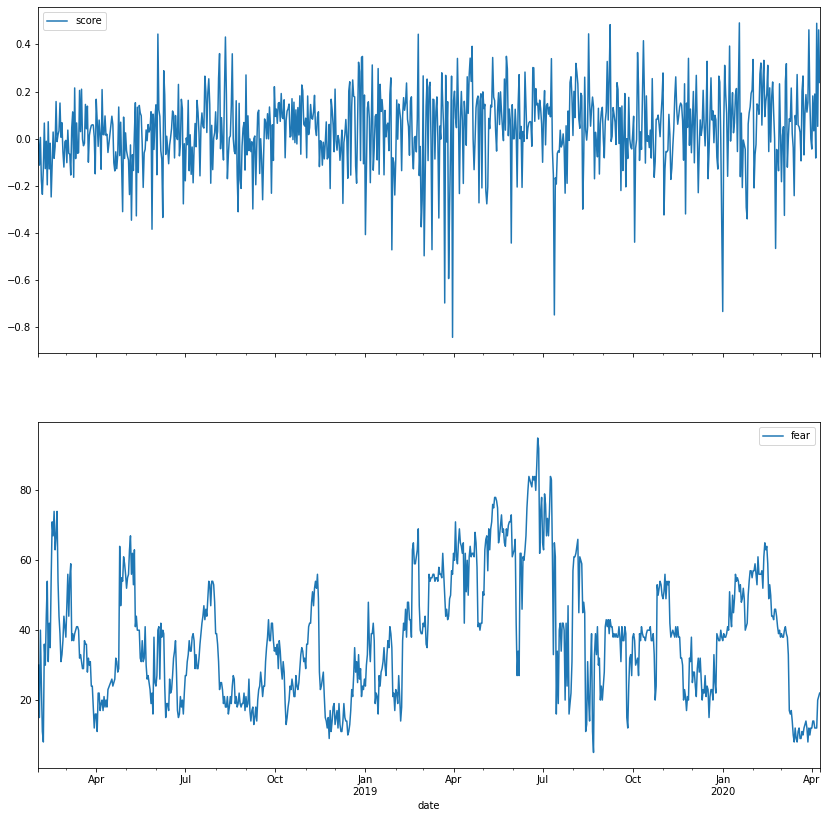

In [ ]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(14,14))
axs = axs.flatten()
for i, col in enumerate(['score', 'fear']):
    fear_sentiment_by_day.plot(x='date',y=[col], ax=axs[i])

The data is too noisy so it's hard to observe any pattern. We thus try to smooth the time series.

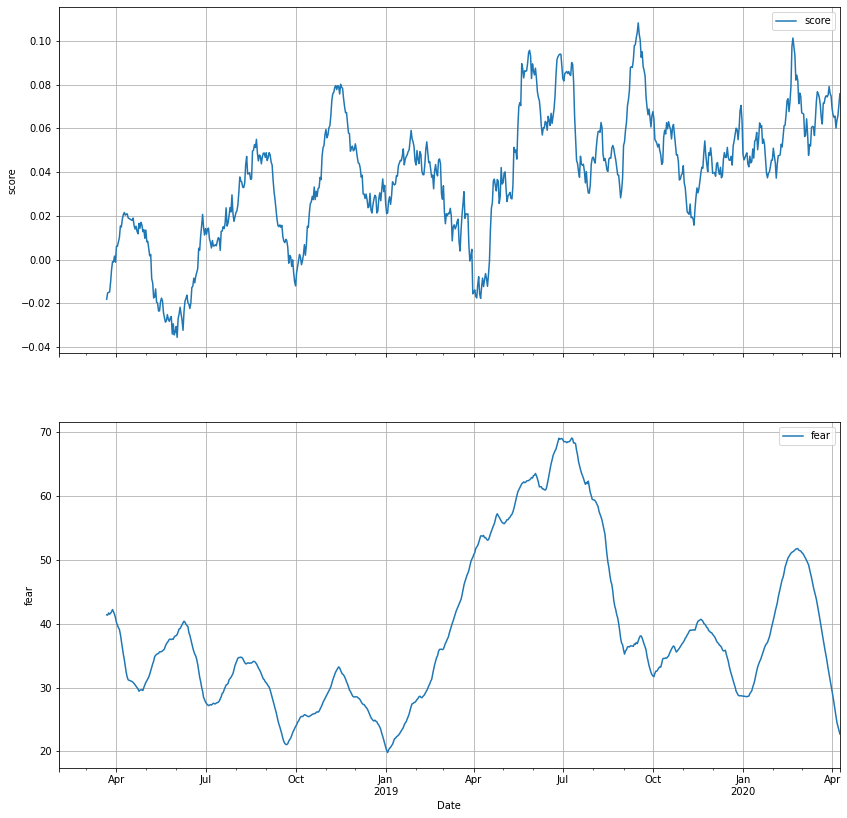

In [ ]:
temp = fear_sentiment_by_day.copy()

temp['score'] = fear_sentiment_by_day['score'].rolling(50).mean()
temp['fear'] = fear_sentiment_by_day['fear'].rolling(50).mean()

fig, axs = plt.subplots(2,1, sharex=True, figsize=(14,14))
axs = axs.flatten()
for i, col in enumerate(['score', 'fear']):
    temp.plot(x='date',y=[col], ax=axs[i], ylabel=col, grid=True, xlabel='Date')


We can observe some patterns start to appear as the data gets visually cleaner.<br>
Let's now perform some causality tests on the unsmoothed data, using granger. 

In [ ]:
MAX_TIME_LAG=30
def causality_test(df, col1, col2):
    # Reference https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/
    causality = False
    test_cols = [col1,col2]
    fig, axes = plt.subplots(1,3, figsize=(24,8))
    for i, (first_col, second_col) in enumerate([test_cols, reversed(test_cols)]):
        granger_test_result = grangercausalitytests(df[[first_col, second_col]], maxlag=MAX_TIME_LAG, verbose=False)
        
        lags, scores =[],[]
        # for each lag we have a score
        for lag in granger_test_result:
            lags.append(lag)
            scores.append(granger_test_result[lag][0]['params_ftest'][0])

        optimal_lag = max(granger_test_result.keys(), key=lambda x: granger_test_result[x][0]['params_ftest'][0])
        if granger_test_result[optimal_lag][0]['params_ftest'][1] < 0.05:
            print("{} granger cause {} with time lag {}".format(second_col, first_col, optimal_lag))
            causality = True
        else:
            print("{} doesn't granger cause {}".format(second_col, first_col))
        axes[i].plot(lags, scores)
        axes[i].set_xlabel("Time Lag [days]")
        axes[i].set_ylabel("F-score")
        axes[i].set_title("Test: {} causes {}, p_value={:.2f}".format(second_col, first_col,granger_test_result[optimal_lag][0]['params_ftest'][1]))
        axes[i].grid(visible=True)
        if causality:
          axes[i].axvline(x = optimal_lag, color='r', linestyle = '--', lw=1)
          axes[i].set_title("Test: {} causes {}, P_value={:.2f}, Optimal lag={} day(s)".format(second_col, first_col,granger_test_result[optimal_lag][0]['params_ftest'][1], optimal_lag))
        else:
          axes[i].set_title("Test: {} causes {}, P_value={:.2f}".format(second_col, first_col,granger_test_result[optimal_lag][0]['params_ftest'][1]))
    # Plot signals
    temp = fear_sentiment_by_day.copy()
    for col in [first_col, second_col]:
        temp[col] = (fear_sentiment_by_day[col]-fear_sentiment_by_day[col].min())\
                        /(fear_sentiment_by_day[col].max()-fear_sentiment_by_day[col].min())
        temp[col] = gaussian_filter1d(temp[col],10)

    temp.plot(x="date", y=[first_col,second_col], ax=axes[2], grid=True)
    plt.show()

fear doesn't granger cause score
score doesn't granger cause fear


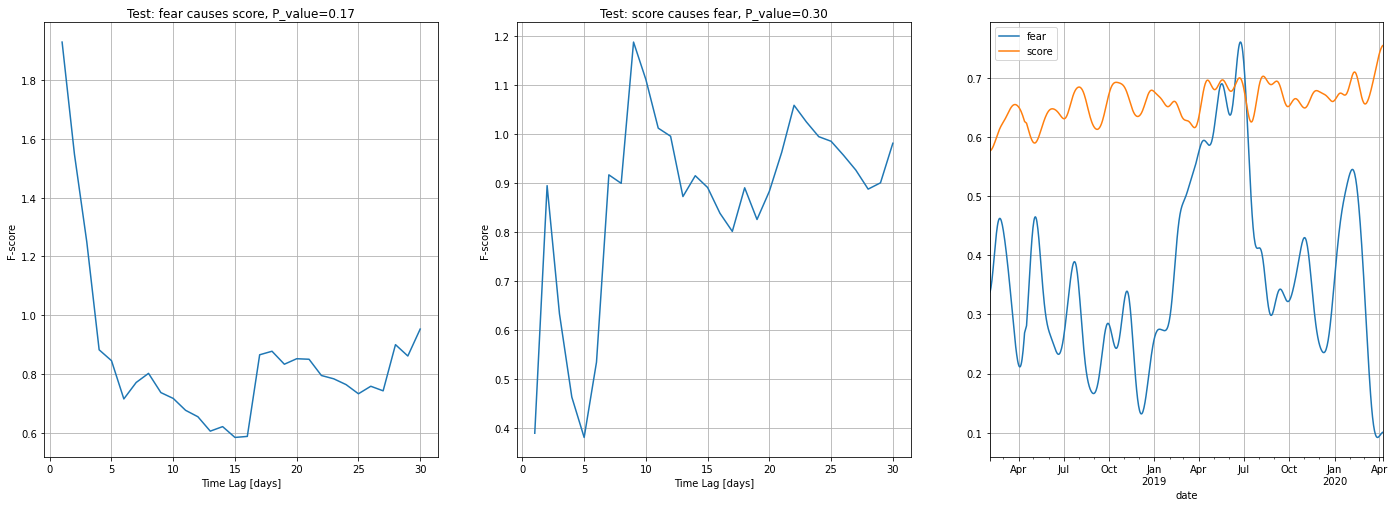

In [ ]:
causality_test(processed_df,'score', 'fear')

Even if we see a high F-score at time lags 1 in the first plot and 9 in the second plot, we cannot conclude any causality because the p-value is too high which actually doesn't give us any insight.

By looking at the definition of fear index, actually, it is not based on the sentiment, but the number of posts on twitter (which could be considered as numOccurences).<BR>
Let's test the relation between numOccurrences, bitcoin price, volume and fear (the factors mentioned in the definition).<br>
PS: High (that you'll see bellow) is the highest bitcoin value of the day.

fear doesn't granger cause numOccurrences
numOccurrences granger cause fear with time lag 1


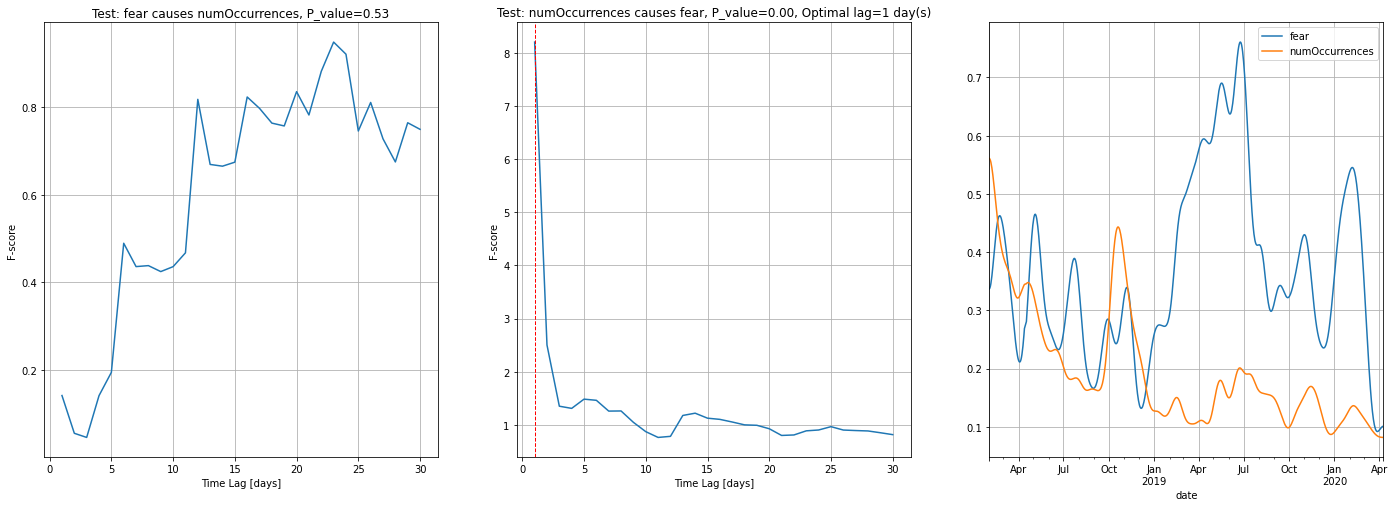

In [ ]:
causality_test(processed_df,'numOccurrences', 'fear')

fear doesn't granger cause High
High granger cause fear with time lag 2


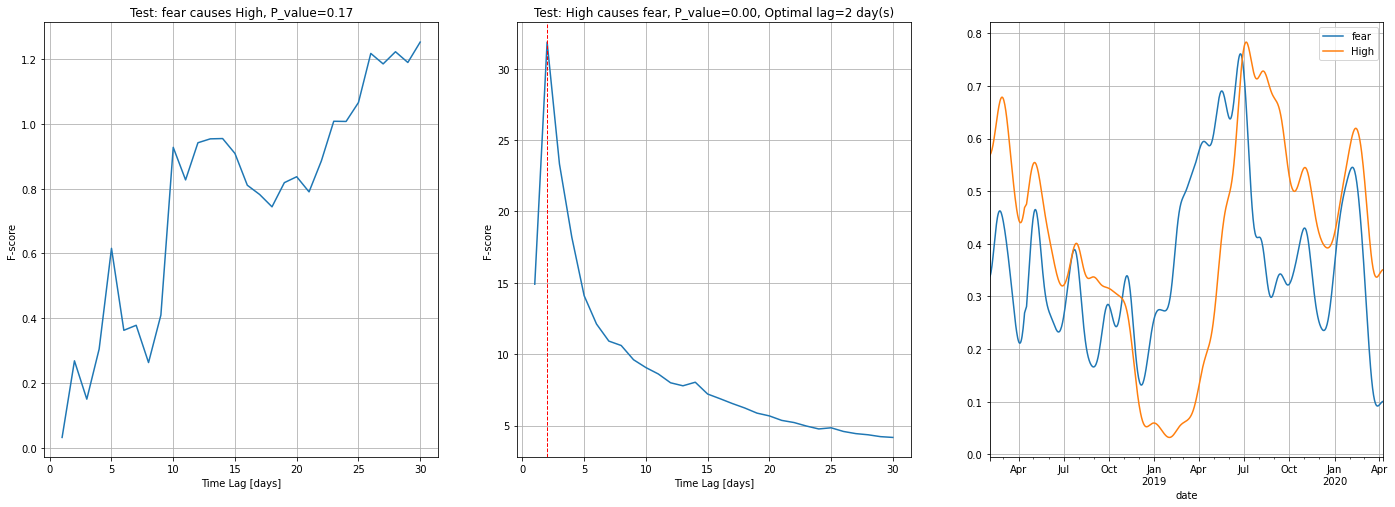

In [ ]:
causality_test(processed_df,'High', 'fear')

fear doesn't granger cause Volume BTC
Volume BTC granger cause fear with time lag 7


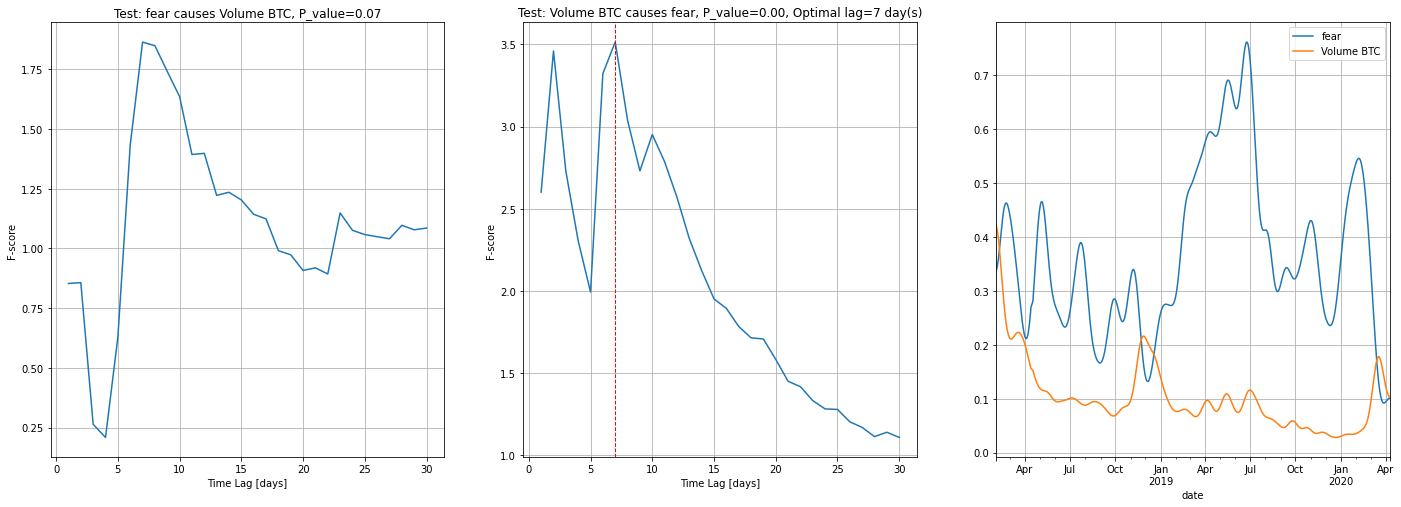

In [ ]:
causality_test(processed_df,'Volume BTC', 'fear')

As expected, numOccurences causes fear with a time lag of 1. <br>
These tests confirm that fear index is impacted by numOccurences, bitcoin volume and bitcoin highest selling price.

Even if said above that fear and score don't cause each other, we clearly observe the similarity between their smoothed time series.
<br> Let's check the possible correlation between them.

The figures below show the relation between score and fear for different jet lags (between -14 which is 14 days before and 14 as 14 days after, you can see the jet lag in the x axis label). For each plot we set as a title the correlation value and p-value.<br>
Our goal is to get a high correlation with a low p-value.

[-7, -6, -5, -4, -3, -2, -1, 0, 1]


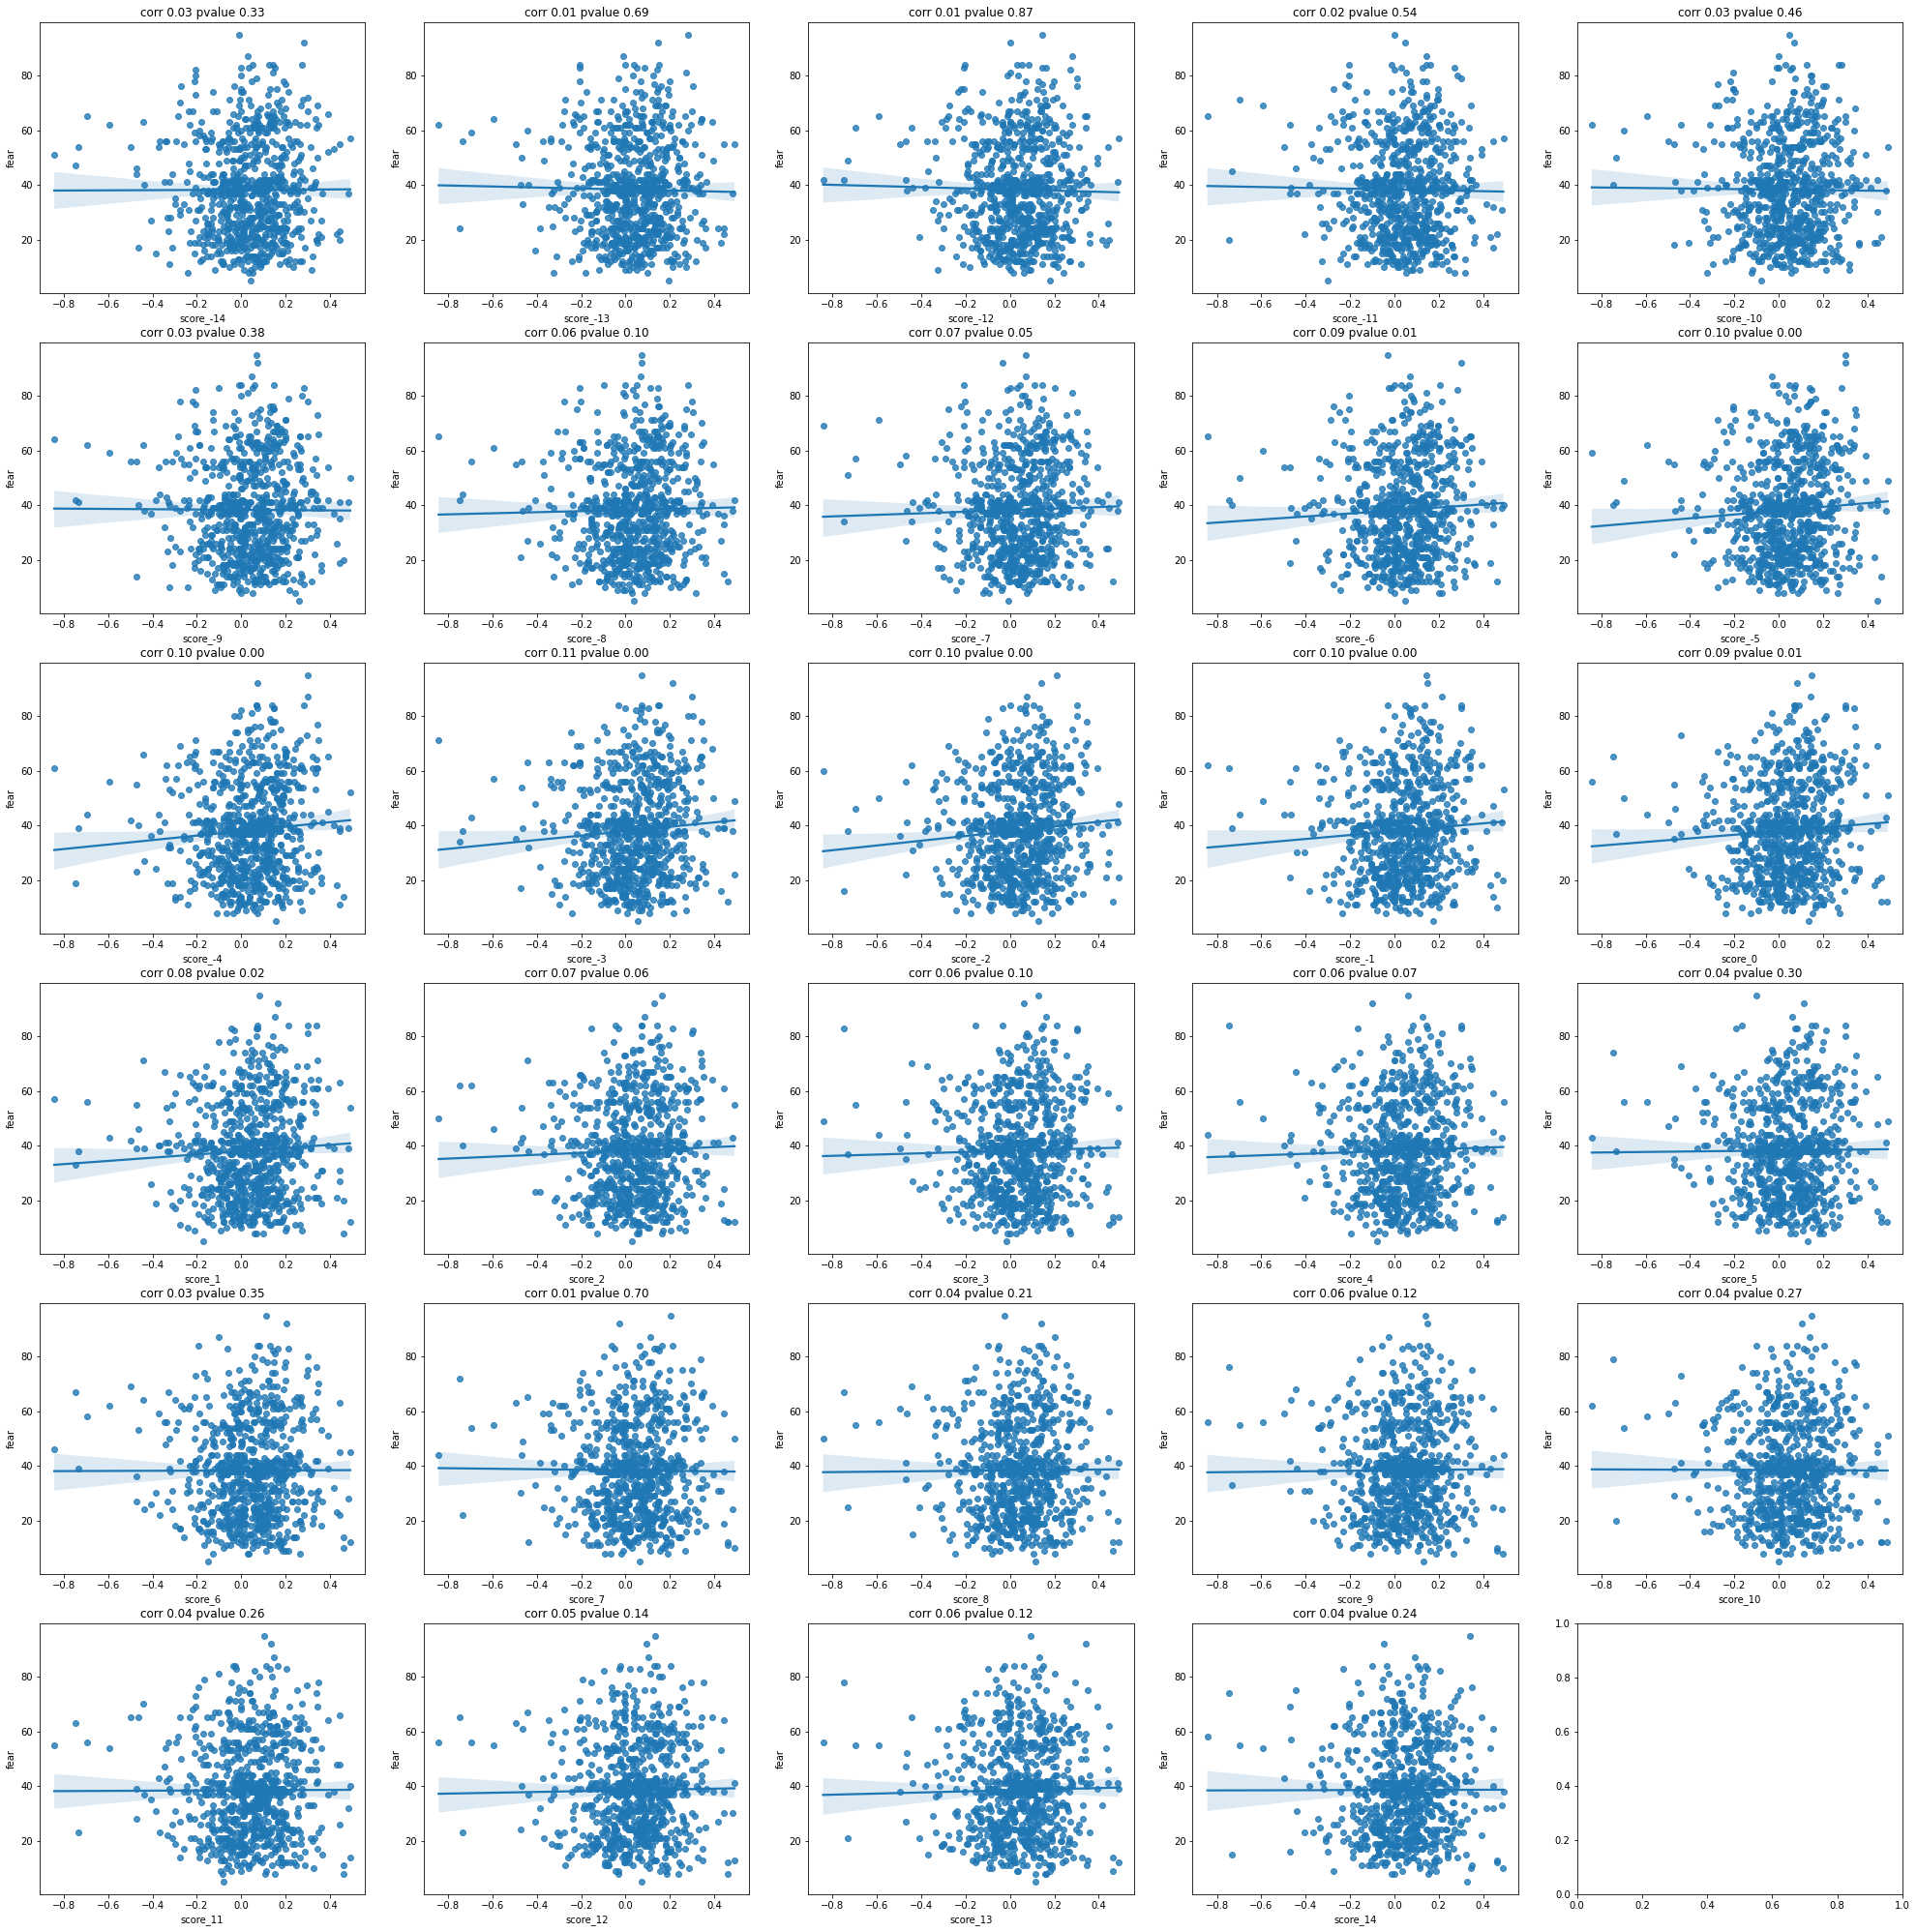

In [ ]:
fig, axs = plt.subplots(6,5, figsize=(28,28))
axs = axs.flatten()
fig.tight_layout(pad=3.0)
# score -> fear
corr = []
pvalue = []
lags = list(range(-14,15))
best_lags = []
for i, lag in enumerate(lags):
    temp = fear_sentiment_by_day.copy()
    temp['fear'] = temp['fear'].shift(lag)
    temp = temp.dropna(subset=['fear','score'])
    
    res = stats.spearmanr(temp['score'].values, temp['fear'].values)
    corr.append(res.correlation)
    pvalue.append(res.pvalue)
    if res.pvalue <=0.05:
        best_lags.append(lag)

    axs[i].set_ylabel('fear')
    ax = sns.regplot(x="score", y="fear", data=temp, ax=axs[i])
    ax.set_title("corr {:.2f} pvalue {:.2f}".format(res.correlation, res.pvalue))
    ax.set_xlabel('score_'+str(lag))
    ax.set_ylabel('fear')
print(best_lags)

We can see that the fear index is correlated to the score in the past and in the future, but with a high p-value, so we take the analysis further to see if we can find some good result as our data is too noisy.

Thus, we test the granger causality on the smoothed data as it seems to be way more relevant visually.

We start by making the smoothed data stationary.

In [ ]:
temp = fear_sentiment_by_day.copy()
temp['score'] = gaussian_filter1d(fear_sentiment_by_day['score'],10)
temp['fear'] = gaussian_filter1d(temp['fear'],10)
# To able to perform causality test, we need the stationary input
for col in ['score','fear']:
    result = adfuller(temp[col])
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'critical_values: {result[4]}')
    if result[1] > 0.05:
        print("Series {} is not stationary".format(col))
        not_stationary_cols.append(col)
    else:
        print("Series {} is stationary".format(col))
    print("=============================")


Test Statistics: -1.3533059868223134
p-value: 0.6044460157870046
critical_values: {'1%': -3.4388159246521433, '5%': -2.865276554696385, '10%': -2.5687597090530696}
Series score is not stationary
Test Statistics: -2.591921954428537
p-value: 0.09467835542307657
critical_values: {'1%': -3.4388268991356936, '5%': -2.8652813916285518, '10%': -2.5687622857867782}
Series fear is not stationary


In [ ]:
transformed_temp = temp.diff().dropna()
for col in ['score','fear']:
    result = adfuller(transformed_temp[col])
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'critical_values: {result[4]}')
    if result[1] > 0.05:
        print("Series {} is not stationary".format(col))
        not_stationary_cols.append(col)
    else:
        print("Series {} is stationary".format(col))
    print("=============================")

Test Statistics: -7.661601907482883
p-value: 1.6829332211978904e-11
critical_values: {'1%': -3.438837902109151, '5%': -2.8652862410999114, '10%': -2.568764869203001}
Series score is stationary
Test Statistics: -4.28531037960532
p-value: 0.00047096309329898114
critical_values: {'1%': -3.4388268991356936, '5%': -2.8652813916285518, '10%': -2.5687622857867782}
Series fear is stationary


fear granger cause score with time lag 2
score granger cause fear with time lag 6


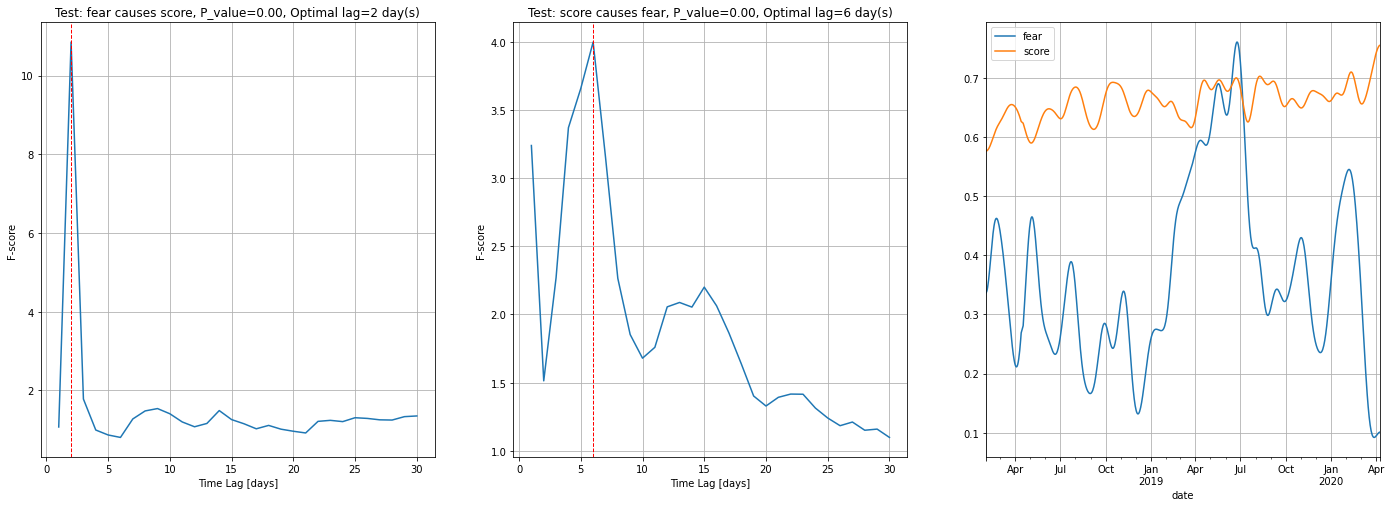

In [ ]:
causality_test(transformed_temp,'score', 'fear')

So after smoothing that some future and past values into account, we can show that the trend of scores and the trend of fear cause each other, as fear causes averagely score with a jetlag of 2, and score causes fear averagely with a jetlag of 6.

# Appendix

In this subsection, you will find some bulk causality tests that don't use the fear index. We test the causality between numOccurences, highest BTC selling price, BTC volume and the score sentiment.<br>
Now we consider a boarder range of time by ignoring the fear index.

In [ ]:
# merge data
numerical_cols = ['ewm_score', 'score','High','Volume BTC','numOccurrences']
time_col = 'date'
bitcoin_sentiment_by_day = quotes_by_day.merge(bitcoin_price, how='left', left_on=time_col, right_on=time_col)
bitcoin_sentiment_by_day = bitcoin_sentiment_by_day[numerical_cols+[time_col]]
bitcoin_sentiment_by_day = bitcoin_sentiment_by_day.fillna({i:0 for i in numerical_cols})
bitcoin_sentiment_by_day = bitcoin_sentiment_by_day.sort_values(by=time_col)
bitcoin_sentiment_by_day

,ewm_score,score,High,Volume BTC,numOccurrences,date
0,0.064273,0.064273,0.0,0.0,3,2015-01-01
1,0.119725,0.161315,0.0,0.0,2,2015-01-02
2,0.045539,-0.051830,0.0,0.0,11,2015-01-05
3,0.014375,-0.039676,0.0,0.0,9,2015-01-06
4,-0.053156,-0.191648,0.0,0.0,13,2015-01-07
...,...,...,...,...,...,...
1632,0.280118,0.344195,0.0,0.0,4,2020-04-12
1633,0.256069,0.183923,0.0,0.0,4,2020-04-13
1634,0.201522,0.037879,0.0,0.0,4,2020-04-14
1635,0.166920,0.063117,0.0,0.0,2,2020-04-15


In [ ]:
# To able to perform causality test, we need the stationary input
not_stationary_cols = []
for col in numerical_cols:
    result = adfuller(bitcoin_sentiment_by_day[col])
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'critical_values: {result[4]}')
    if result[1] > 0.05:
        print("Series {} is not stationary".format(col))
        not_stationary_cols.append(col)
    else:
        print("Series {} is stationary".format(col))
    print("=============================")

Test Statistics: -10.137358952230214
p-value: 8.599114694820955e-18
critical_values: {'1%': -3.434358324786104, '5%': -2.8633104444209136, '10%': -2.5677125453453167}
Series ewm_score is stationary
Test Statistics: -9.716587081957204
p-value: 9.792983461193792e-17
critical_values: {'1%': -3.4343755975140455, '5%': -2.8633180685073194, '10%': -2.5677166050955584}
Series score is stationary
Test Statistics: -1.8922755756783183
p-value: 0.33570360364906837
critical_values: {'1%': -3.4344156425955177, '5%': -2.86333574401553, '10%': -2.5677260171554885}
Series High is not stationary
Test Statistics: -2.5319159681025685
p-value: 0.10790065897394152
critical_values: {'1%': -3.434403043188966, '5%': -2.863330182785859, '10%': -2.567723055843177}
Series Volume BTC is not stationary
Test Statistics: -3.376469056600584
p-value: 0.011787678196100604
critical_values: {'1%': -3.4344105934445004, '5%': -2.8633335153825383, '10%': -2.5677248304249916}
Series numOccurrences is stationary


In [ ]:
if len(not_stationary_cols)>0:
    print("Transform data by take the first difference (difference between two consecutive days)")
    transformed_fear_sentiment_by_day = bitcoin_sentiment_by_day.diff().dropna()
    processed_df = bitcoin_sentiment_by_day[['date']+[i for i in numerical_cols if i not in not_stationary_cols]].join(transformed_fear_sentiment_by_day[not_stationary_cols],how='right')
    # check the stationary again
    for col in not_stationary_cols:
        result = adfuller(processed_df[col])
        print(f'Test Statistics: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'critical_values: {result[4]}')
        if result[1] > 0.05:
            print("Series {} is not stationary".format(col))
        else:
            print("Series {} is stationary".format(col))
        print("=============================")
else:
    print("We don't need transform data")
    processed_df = bitcoin_sentiment_by_day.copy()

Transform data by take the first difference (difference between two consecutive days)
Test Statistics: -7.104349296216285
p-value: 4.0902855342001695e-10
critical_values: {'1%': -3.4344156425955177, '5%': -2.86333574401553, '10%': -2.5677260171554885}
Series High is stationary
Test Statistics: -15.362928383336738
p-value: 3.59241364430952e-28
critical_values: {'1%': -3.434403043188966, '5%': -2.863330182785859, '10%': -2.567723055843177}
Series Volume BTC is stationary


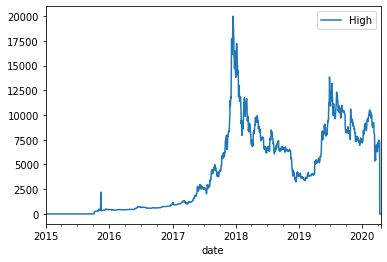

In [ ]:
bitcoin_sentiment_by_day.plot(x=time_col, y=['High'])

Based on the figure above, we can consider 3 time periods

In [ ]:
first_period_df = processed_df[processed_df['date'] < '2017-06-01']
second_period_df = processed_df[(processed_df['date'] >= '2017-06-01')&(processed_df['date'] < '2019-01-01')]
third_period_df = processed_df[processed_df['date'] >= '2019-01-01']

High granger cause numOccurrences with time lag 19
numOccurrences doesn't granger cause High


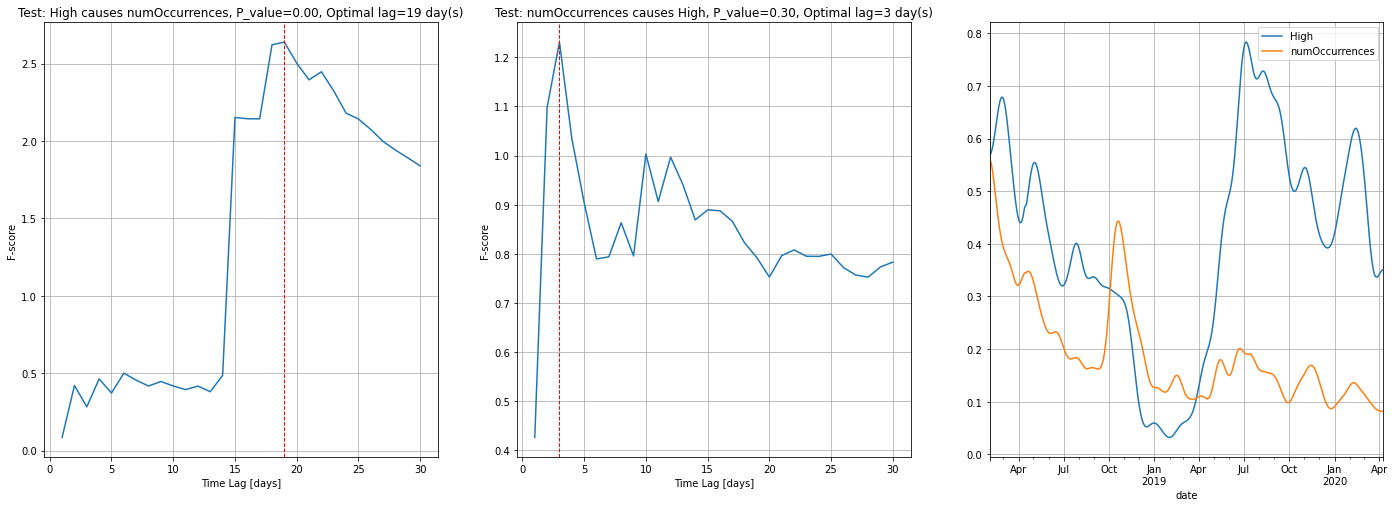

High granger cause numOccurrences with time lag 14
numOccurrences granger cause High with time lag 9


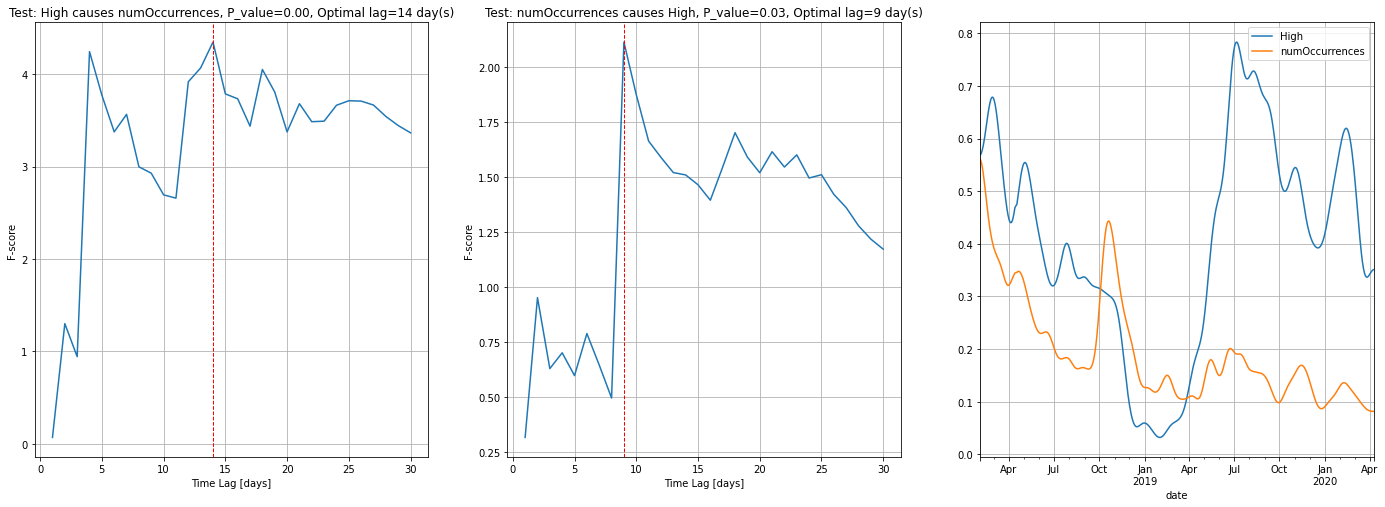

High doesn't granger cause numOccurrences
numOccurrences doesn't granger cause High


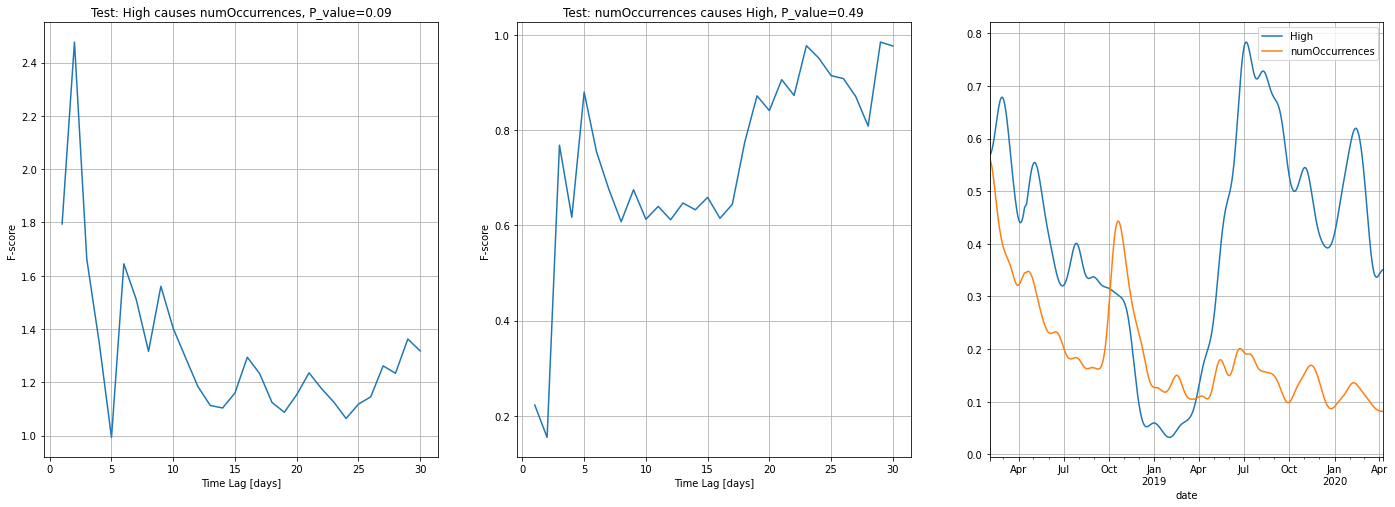

In [ ]:
causality_test(first_period_df,'numOccurrences', 'High')
causality_test(second_period_df,'numOccurrences', 'High')
causality_test(third_period_df,'numOccurrences', 'High')

High and numOccurrences only cause each other in the second period, when the price was high. before and after the bubble, people tend not to be affected by these statement . There could be some sort of correlation but not granger causality

Volume BTC granger cause numOccurrences with time lag 15
numOccurrences granger cause Volume BTC with time lag 6


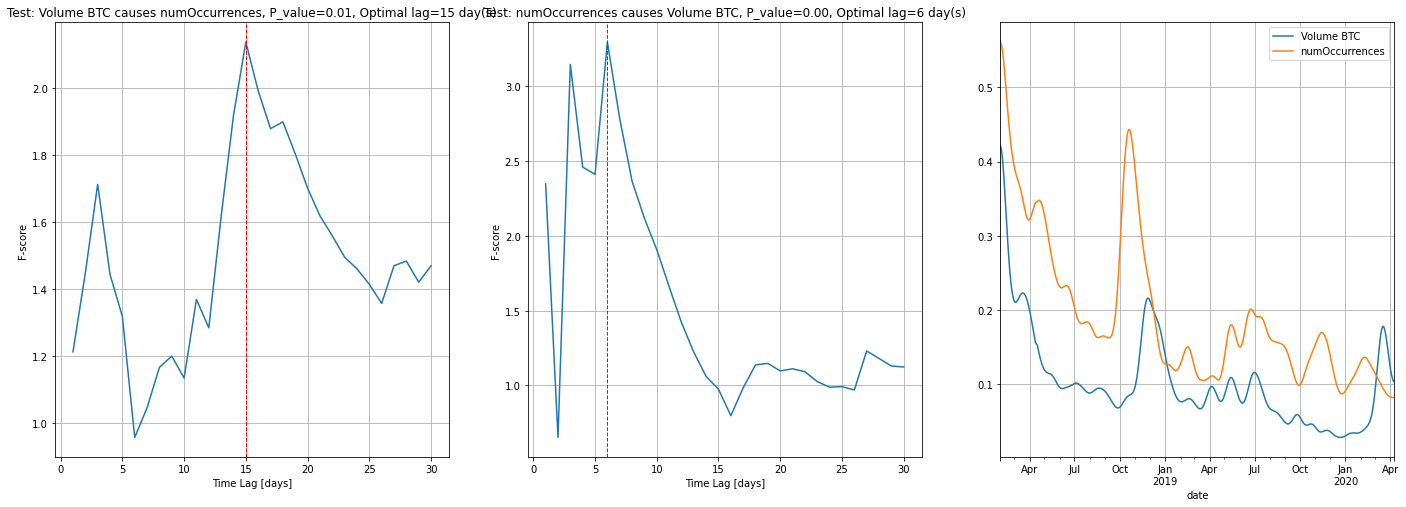

Volume BTC granger cause numOccurrences with time lag 3
numOccurrences granger cause Volume BTC with time lag 2


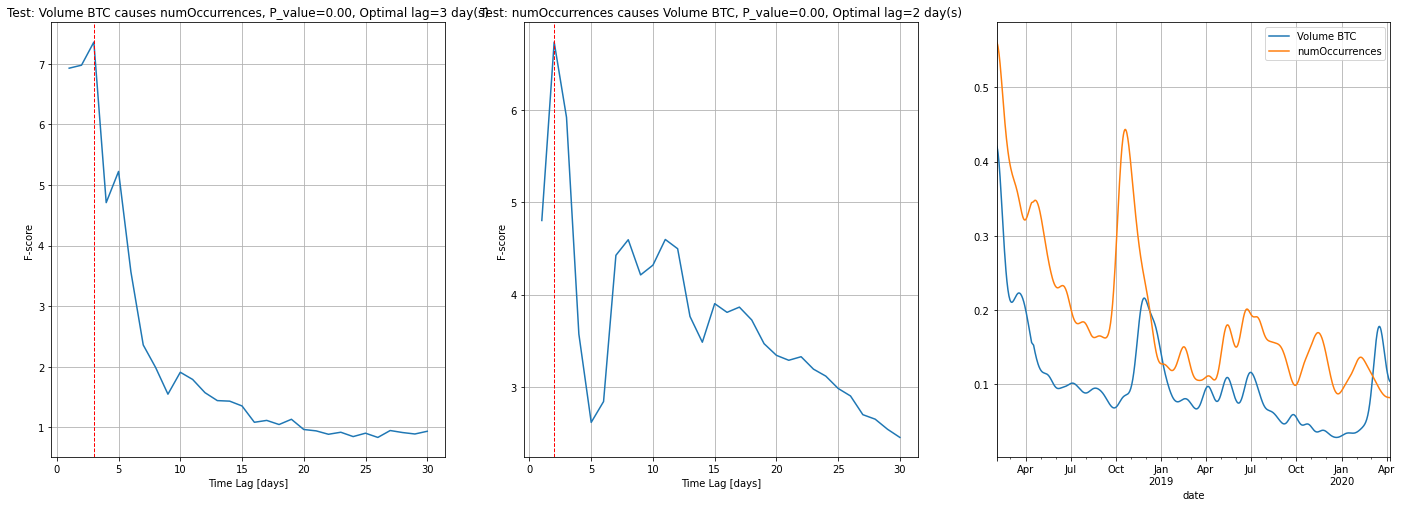

Volume BTC granger cause numOccurrences with time lag 1
numOccurrences granger cause Volume BTC with time lag 2


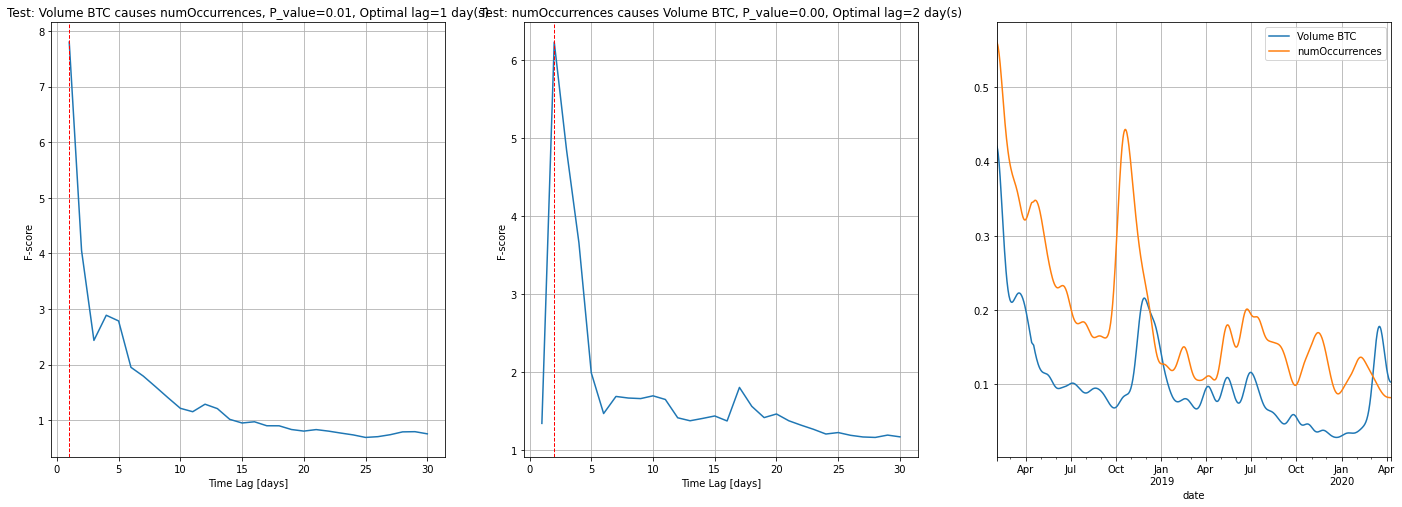

In [ ]:
causality_test(first_period_df,'numOccurrences', 'Volume BTC')
causality_test(second_period_df,'numOccurrences', 'Volume BTC')
causality_test(third_period_df,'numOccurrences', 'Volume BTC')

Volume BTC and numOccurrences cause each other through all three periods, but after the increase of price, the lag become smaller. That mean the market respond faster with the media.

Volume BTC doesn't granger cause score
score doesn't granger cause Volume BTC


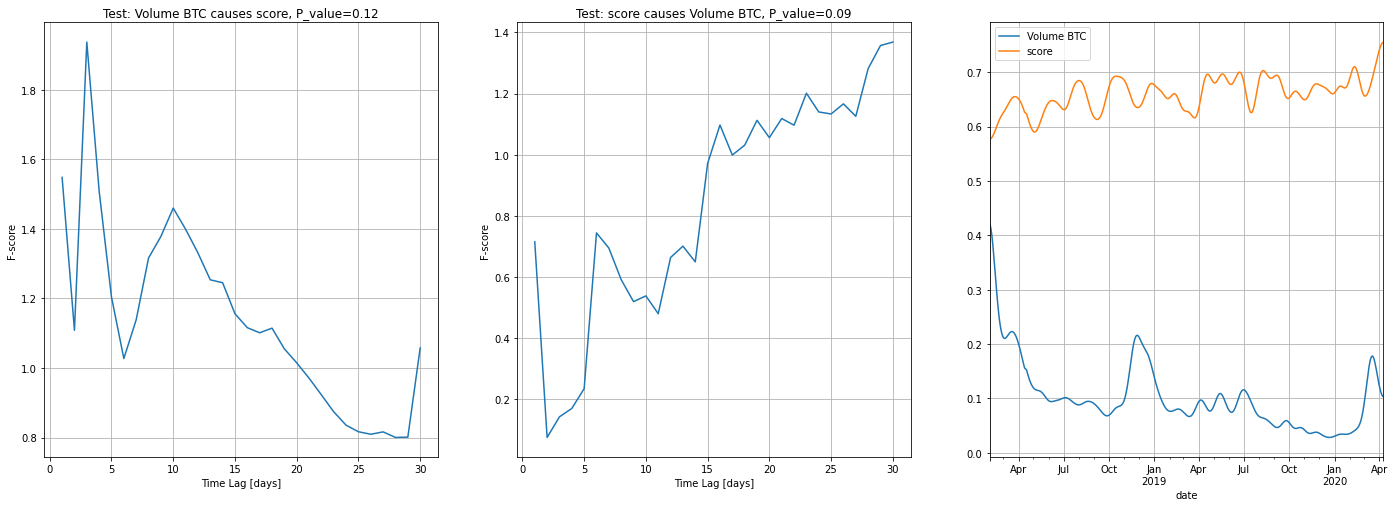

Volume BTC granger cause score with time lag 2
score doesn't granger cause Volume BTC


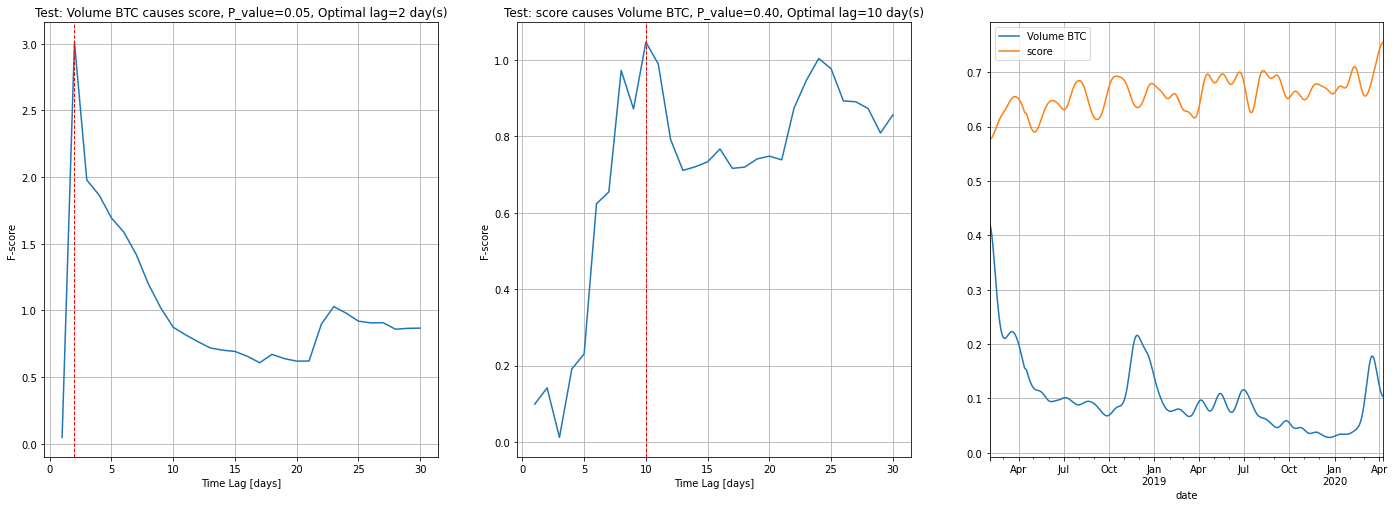

Volume BTC doesn't granger cause score
score doesn't granger cause Volume BTC


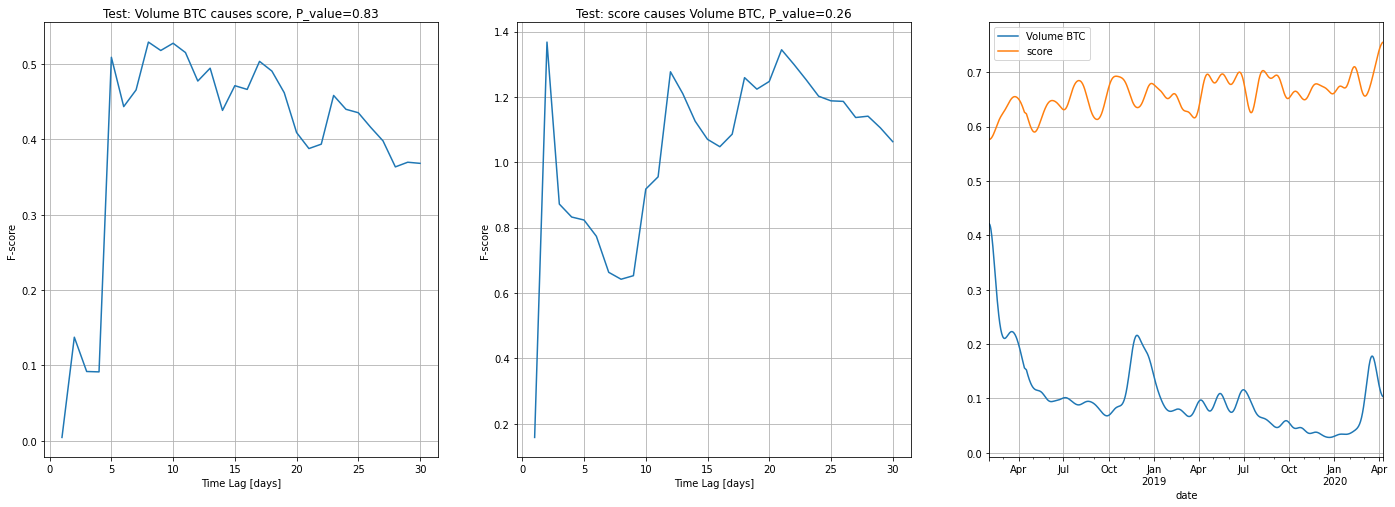

In [ ]:
causality_test(first_period_df,'score', 'Volume BTC')
causality_test(second_period_df,'score', 'Volume BTC')
causality_test(third_period_df,'score', 'Volume BTC')

High doesn't granger cause score
score granger cause High with time lag 1


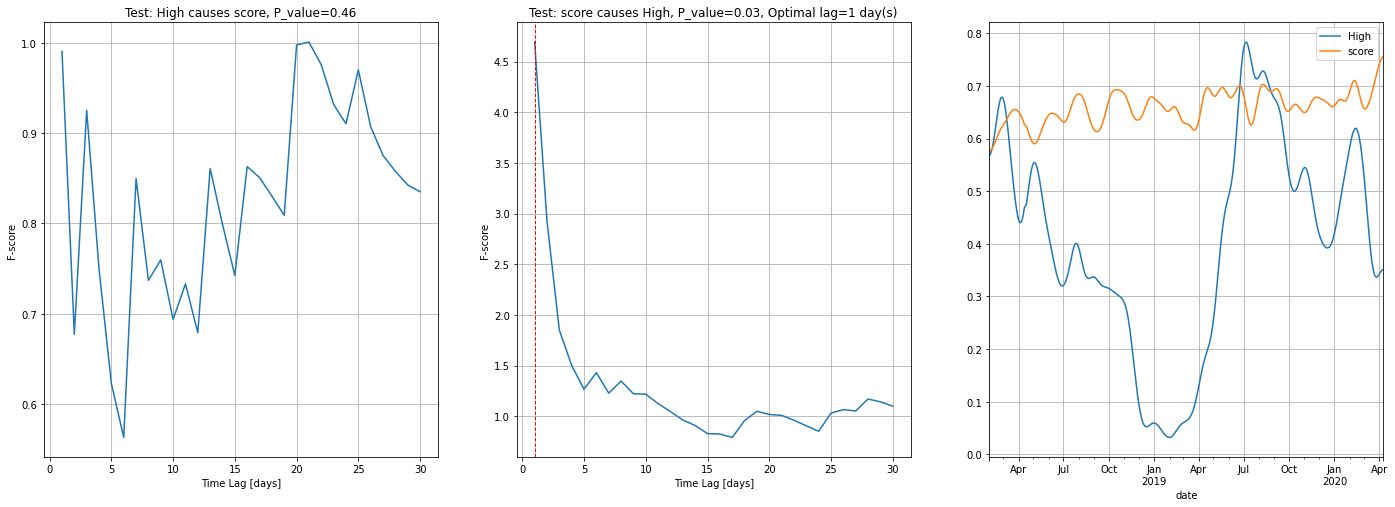

High doesn't granger cause score
score doesn't granger cause High


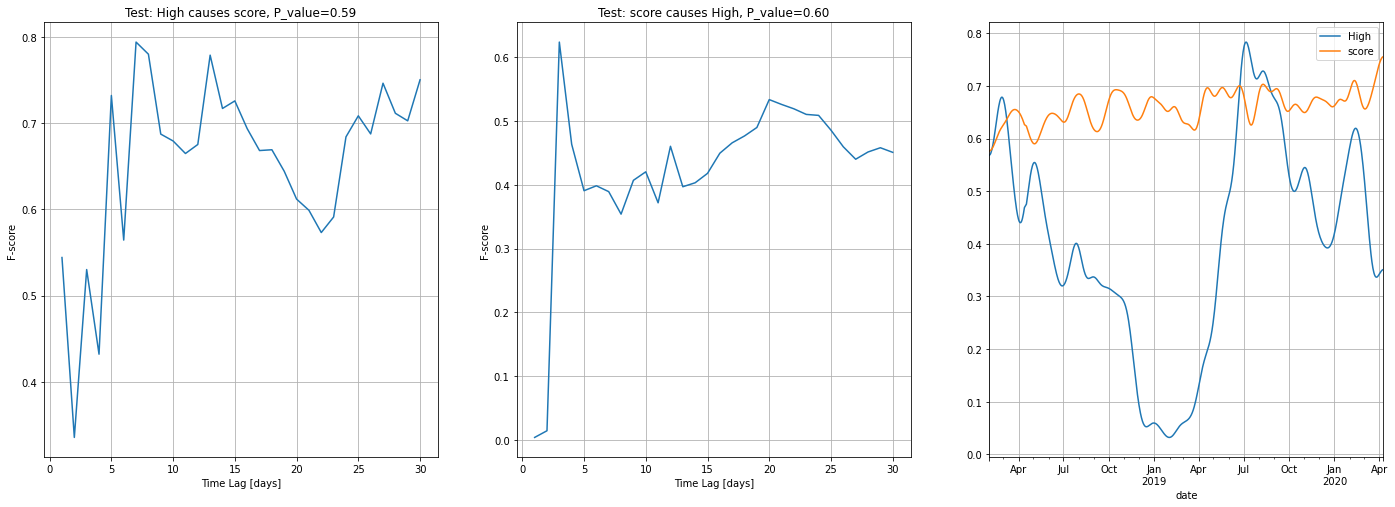

High doesn't granger cause score
score granger cause High with time lag 5


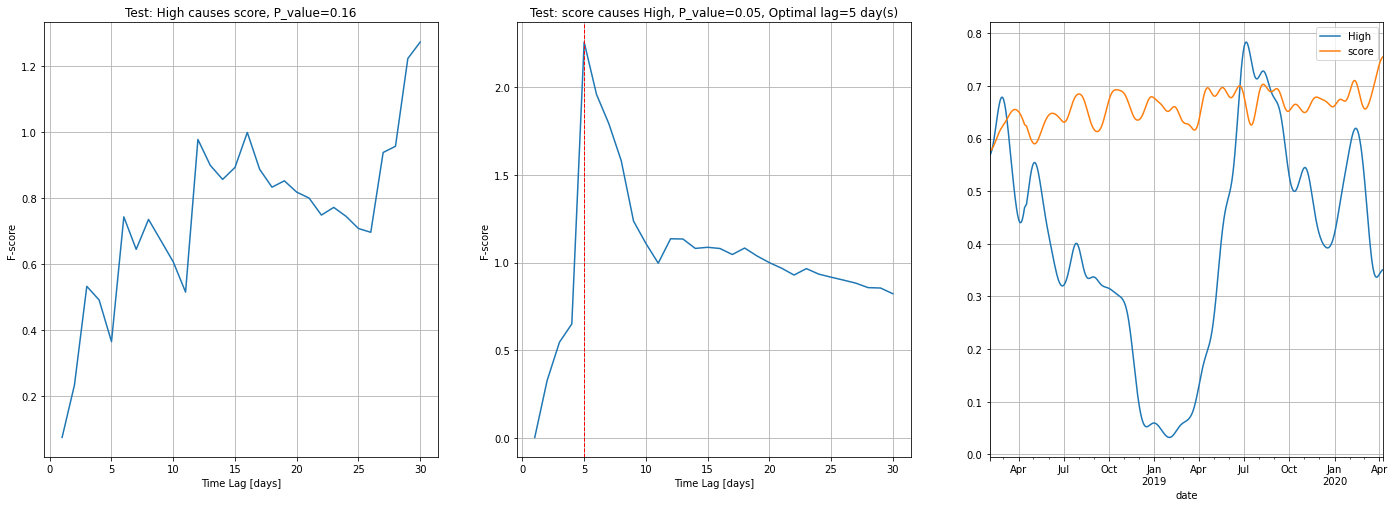

In [ ]:
causality_test(first_period_df,'score', 'High')
causality_test(second_period_df,'score', 'High')
causality_test(third_period_df,'score', 'High')

Thus, the score averagely causes highest selling price with a relatively small time lag.